In [1]:
import numpy as np
import math
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def switch_player(player):
    if player.lower() == "row":
        return "col";
    elif player.lower() == "col":
        return "row";
    else:
        raise ValueError("Was not a valid player!")

In [3]:
# "global" constants
all_games = dict(
    pd = [[8, 8], # Result 1
          [0,12], # 2
          [12,0], # 3
          [4, 4]] # 4
    ,
    threat = [[12,6],
              [6,12],
              [6,0],
              [0,6]]
    ,
    disjunctive = [[12,12],
                   [12,12],
                   [12,12],
                   [0,0]]
    ,
    coordination = [[12,12],
                  [ 0, 0],
                  [ 0, 0],
                  [12,12]]
    ,
    singleControl = [[6, 6],
                  [0, 6],
                  [6, 6],
                  [0, 6]]
)

In [4]:
def normalize(probs):
    total = math.fsum(probs)
    ret_res = []

    for i in range(len(probs)):
        ret_res.append(probs[i]/total)
    
    return ret_res;

In [5]:
def calculate_TU(result, w1, w2, g, player):
    u1 = result[0]
    u2 = result[1]
    
    # alternate perspectives
    if player.lower() == "row":
        return (w1 * u1) + (g * w2 * u2);
    elif player.lower() == "col":
        return (w1 * u2) + (g * w2 * u1);
    else:
        raise ValueError("Was not a valid player!")

In [6]:
def calculate_EU(u1, u2, p1=0.5, p2=0.5):
    return (u1 * p1) + (u2 * p2); # p: probs of choices

In [7]:
def calculate_probs(eu_choice, eu_other): # probability of a choice
    return np.exp(eu_choice) / (np.exp(eu_choice) + np.exp(eu_other))

In [8]:
def predict(all_tu, player):  # "innermost" call in recursion
    all_eu = [] # keeps default p=0.5 values - see calculate_EU
    if player.lower() == "row":
        all_eu.append(calculate_EU(all_tu[0], all_tu[1])) #a1
        all_eu.append(calculate_EU(all_tu[2], all_tu[3])) #a2
    elif player.lower() == "col":
        all_eu.append(calculate_EU(all_tu[0], all_tu[2])) #b1
        all_eu.append(calculate_EU(all_tu[1], all_tu[3])) #b2
    else:
        raise ValueError("Was not a valid player!")
    
    probs = []
    probs.append(calculate_probs(all_eu[0], all_eu[1])) # a1 or b1
    probs.append(calculate_probs(all_eu[1], all_eu[0])) # a2 or b2
    
    return probs;

In [9]:
def predict2(game, w22, w21, g, player, r):
    all_tu = [] # array of total utilities for player in each result
    for result in game:
        all_tu.append(calculate_TU(result, w22, w21, g, player))
        
    all_eu = []  
    all_eu.append(all_tu[0] * r[0]) #a1b1
    all_eu.append(all_tu[1] * r[1]) #a1b2
    all_eu.append(all_tu[2] * r[2]) #a2b1
    all_eu.append(all_tu[3] * r[3]) #a2b2
    
    probs = []
    if player.lower() == "row":
        probs.append(calculate_probs(all_eu[0], all_eu[2])) # b1a1
        probs.append(calculate_probs(all_eu[1], all_eu[3])) # b2a1
        probs.append(calculate_probs(all_eu[2], all_eu[0])) # b1a2
        probs.append(calculate_probs(all_eu[3], all_eu[1])) # b2a2
    elif player.lower() == "col":
        probs.append(calculate_probs(all_eu[0], all_eu[1])) # a1b1
        probs.append(calculate_probs(all_eu[1], all_eu[0])) # a1b2
        probs.append(calculate_probs(all_eu[2], all_eu[3])) # a2b1
        probs.append(calculate_probs(all_eu[3], all_eu[2])) # a2b2
    
    return probs;

In [10]:
predict2(all_games["coordination"], 1, 0, 1, "col", [0.00495, 0.00495, 0.00495, 0.00495])

[0.51484563519455406,
 0.48515436480544599,
 0.48515436480544599,
 0.51484563519455406]

In [11]:
def predict_recursive(game, w1, w2, g, player): # player is current level i.e. A (me) simulating B -> player=B
    all_tu = [] # array of total utilities for player in each result
    for result in game:
        all_tu.append(calculate_TU(result, w1, w2, g, player))
        
#     print(all_tu)
    
    p = predict(all_tu, switch_player(player)) # probs based on p1 = p2 = 0.5
    
    all_eu = []
    if player.lower() == "row":
        all_eu.append(calculate_EU(all_tu[0], all_tu[1], p[0], p[1])) #a1
        all_eu.append(calculate_EU(all_tu[2], all_tu[3], p[0], p[1])) #a2
    elif player.lower() == "col":
        all_eu.append(calculate_EU(all_tu[0], all_tu[2], p[0], p[1])) #b1
        all_eu.append(calculate_EU(all_tu[1], all_tu[3], p[0], p[1])) #b2
        
#     print(all_eu)
    
    probs = []
    probs.append(calculate_probs(all_eu[0], all_eu[1])) # a1 or b1
    probs.append(calculate_probs(all_eu[1], all_eu[0])) # a2 or b2
    
    return probs;

In [12]:
# predict_recursive(all_games["threat"], 1, 0, 1, "a")

In [13]:
# P(first choice|params)
def get_choice1_probs(game, player1):
    outcomes = []
#     total_count = np.linspace(-0.5,1.0,101).size
    for w12 in np.arange(-1, 0, 0.02):
        w11 = w12 + 1
        P = predict_recursive(game, w11, w12, 1, player1)
        outcomes.append({"gamma":-1,
                         "w11":w11,
                         "w12":-w12,
                         "player1":player1,
                         "P(params|cA)":P[0],
                         "P(params|cB)":P[1]})
    
    for w12 in np.arange(0, 1.01, 0.02):
        w11 = 1 - w12
        P = predict_recursive(game, w11, w12, 1, player1)
        outcomes.append({"gamma":1,
                         "w11":w11,
                         "w12":w12,
                         "player1":player1,
                         "P(params|cA)":P[0],
                         "P(params|cB)":P[1]}) # ex: returns simulation of player B
                
    return pd.DataFrame(outcomes);

In [14]:
# P(params|first choice)
def get_param_set1_probs(choice_probs):
    ret = choice_probs
    
    length = choice_probs.shape[0]
    
    ret["P(params|cA)"] = ret["P(params|cA)"] / length
    ret["P(params|cB)"] = ret["P(params|cB)"] / length
    
    return ret;

In [15]:
def get_choice2_probs(game, player2, r1):
    outcomes = []
#     total_count = r1.shape[0]
    p1 = []
    r = []
    R = []
    for index, row in r1.iterrows():
#         print(row.iloc[0:2].tolist())
        p1 = row.iloc[0:2].tolist()
        if switch_player(player2) == "row":
            r = [val for val in p1 for _ in (0, 1)]
        elif switch_player(player2) == "col":
            r = [val for val in p1] * 2
        
        P = predict2(game, row.w11, row.w12, row.gamma, player2, r)
#         print(P)
        
        for i in range(0, 4):
#             print(P[i]*r[i])
            R.append(P[i] * r[i])
            
#         print(R)
            
        outcomes.append({"gamma":row.gamma,
                         "w11":row.w11,
                         "w12":row.w12,
                         "P(params|out0)":R[0],
                         "P(params|out1)":R[1],
                         "P(params|out2)":R[2],
                         "P(params|out3)":R[3]})
        
        R = []  # don't forget to reset R
        
    return pd.DataFrame(outcomes);

In [16]:
get_choice2_probs(all_games.get("singleControl"), "row", get_choice1_probs(all_games.get("singleControl"), "col"))

,P(params|out0),P(params|out1),P(params|out2),P(params|out3),gamma,w11,w12
0,0.001236,0.498764,0.001236,0.498764,-1,0.00,1.00
1,0.001393,0.498607,0.001393,0.498607,-1,0.02,0.98
2,0.001571,0.498429,0.001571,0.498429,-1,0.04,0.96
3,0.001770,0.498230,0.001770,0.498230,-1,0.06,0.94
4,0.001995,0.498005,0.001995,0.498005,-1,0.08,0.92
5,0.002248,0.497752,0.002248,0.497752,-1,0.10,0.90
6,0.002533,0.497467,0.002533,0.497467,-1,0.12,0.88
7,0.002854,0.497146,0.002854,0.497146,-1,0.14,0.86
8,0.003216,0.496784,0.003216,0.496784,-1,0.16,0.84
9,0.003623,0.496377,0.003623,0.496377,-1,0.18,0.82


In [17]:
# P(params|both choices)
def get_param_set2_probs(choice_probs):
    ret = choice_probs
    
    length = choice_probs.shape[0]
    
    ret["P(params|out0)"] = ret["P(params|out0)"] / length
    ret["P(params|out1)"] = ret["P(params|out1)"] / length
    ret["P(params|out2)"] = ret["P(params|out2)"] / length
    ret["P(params|out3)"] = ret["P(params|out3)"] / length
    
    return ret;

# Testing

In [18]:
p = [0.1, 0.9]
[val for val in p for _ in (0, 1)]
p * 2

[0.1, 0.9, 0.1, 0.9]

In [19]:
a = (0, 1)
a[1]

1

In [20]:
np.linspace(-1.0,1.0,101)

array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
       -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
       -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
       -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
       -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12,
       -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
        0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,
        0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,
        0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,
        0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,
        0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,
        0.98,  1.  ])

In [21]:
np.arange(0,1.01,0.02)

array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
        0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
        0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
        0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
        0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
        0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ])

In [22]:
test_game = all_games["singleControl"]
test = get_param_set1_probs(get_choice1_probs(test_game, "col"))
test.iloc[40:60]

,P(params|cA),P(params|cB),gamma,player1,w11,w12
40,0.002292,0.007609,-1,col,0.80,0.20
41,0.002510,0.007391,-1,col,0.82,0.18
42,0.002741,0.007160,-1,col,0.84,0.16
43,0.002985,0.006915,-1,col,0.86,0.14
44,0.003242,0.006659,-1,col,0.88,0.12
45,0.003508,0.006393,-1,col,0.90,0.10
46,0.003785,0.006116,-1,col,0.92,0.08
47,0.004069,0.005832,-1,col,0.94,0.06
48,0.004359,0.005542,-1,col,0.96,0.04
49,0.004654,0.005247,-1,col,0.98,0.02


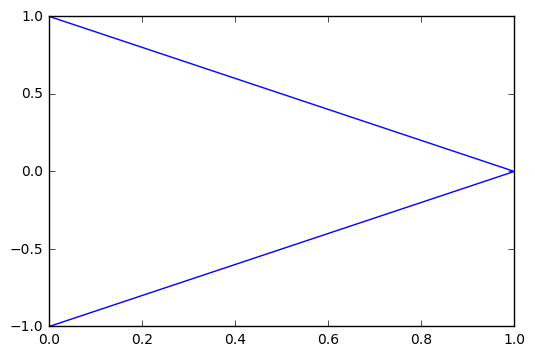

In [23]:
# sanity check
plt.plot(test.w11, test.w12*test.gamma)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.show()

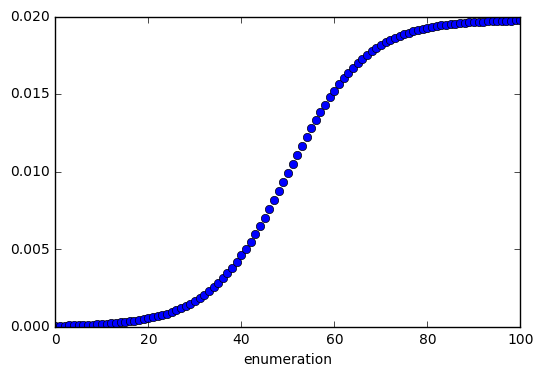

In [24]:
plt.plot(list(range(101)), normalize(test["P(params|cA)"]), "o")
# plt.plot(list(range(101)), normalize(test["P(params|cB)"]), "o")
# plt.ylabel("P(params|cB)")
plt.xlabel("enumeration")
plt.show()

In [25]:
# could also use dot product or manual summation
np.average(list(range(101)), weights=normalize(test["P(params|cA)"])) # expected value of enumeration, round to nearest int
# test.iloc[50]

73.032422828713081

In [26]:
test_b = get_param_set2_probs(get_choice2_probs(test_game, "row", test))
test_b

,P(params|out0),P(params|out1),P(params|out2),P(params|out3),gamma,w11,w12
0,1.211951e-07,4.889361e-05,1.211951e-07,4.889361e-05,-1,0.00,1.00
1,1.366041e-07,4.887820e-05,1.366041e-07,4.887820e-05,-1,0.02,0.98
2,1.539659e-07,4.886084e-05,1.539659e-07,4.886084e-05,-1,0.04,0.96
3,1.735266e-07,4.884128e-05,1.735266e-07,4.884128e-05,-1,0.06,0.94
4,1.955625e-07,4.881924e-05,1.955625e-07,4.881924e-05,-1,0.08,0.92
5,2.203839e-07,4.879442e-05,2.203839e-07,4.879442e-05,-1,0.10,0.90
6,2.483398e-07,4.876646e-05,2.483398e-07,4.876646e-05,-1,0.12,0.88
7,2.798216e-07,4.873498e-05,2.798216e-07,4.873498e-05,-1,0.14,0.86
8,3.152685e-07,4.869953e-05,3.152685e-07,4.869953e-05,-1,0.16,0.84
9,3.551730e-07,4.865963e-05,3.551730e-07,4.865963e-05,-1,0.18,0.82


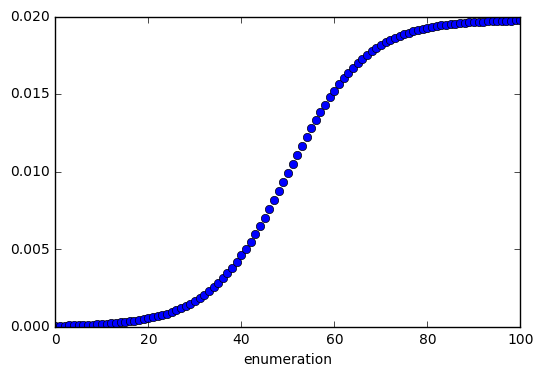

In [27]:
plt.plot(list(range(101)), normalize(test_b["P(params|out0)"]), "o")
# plt.plot(list(range(101)), normalize(test_b["P(params|out1)"]), "o")
# plt.plot(list(range(101)), normalize(test_b["P(params|out2)"]), "o")
# plt.plot(list(range(101)), normalize(test_b["P(params|out3)"]), "o")
plt.xlabel("enumeration")
plt.show()

# Generate

In [28]:
def generate_first_results(player1):
    results = []
    for game in list(all_games.keys()):
        p = get_param_set1_probs(get_choice1_probs(all_games.get(game), player1))
        results.append({"game":game,
                       "E[param index|cA]":np.round(np.average(list(range(101)), weights=normalize(p["P(params|cA)"])),0),
                       "E[param index|cB]":np.round(np.average(list(range(101)), weights=normalize(p["P(params|cB)"])),0)})
        
    return pd.DataFrame(results)

In [29]:
pd.concat([generate_first_results("row"),generate_first_results("col")], keys=["row","column"])

E[param index|cA]  E[param index|cB]           game
row    0               62.0               14.0         threat
       1               50.0               50.0   coordination
       2               83.0               34.0             pd
       3               50.0               50.0  singleControl
       4               60.0               43.0    disjunctive
column 0               86.0               38.0         threat
       1               50.0               50.0   coordination
       2               83.0               34.0             pd
       3               73.0               27.0  singleControl
       4               60.0               43.0    disjunctive

In [30]:
def generate_second_results(player2):
    results = []
    for game in list(all_games.keys()):
        r1 = get_choice1_probs(all_games.get(game), switch_player(player2))
        p = get_param_set2_probs(get_choice2_probs(all_games.get(game), player2, r1))
        results.append({"game":game,
                       "E[param index|out0]":np.round(np.average(list(range(101)), weights=normalize(p["P(params|out0)"])),0),
                       "E[param index|out1]":np.round(np.average(list(range(101)), weights=normalize(p["P(params|out1)"])),0),
                       "E[param index|out2]":np.round(np.average(list(range(101)), weights=normalize(p["P(params|out2)"])),0),
                       "E[param index|out3]":np.round(np.average(list(range(101)), weights=normalize(p["P(params|out3)"])),0)})
        
    return pd.DataFrame(results)

In [31]:
pd.concat([generate_second_results("col"),generate_second_results("row")], keys=["row,column","column,row"])

E[param index|out0]  E[param index|out1]  E[param index|out2]  \
row,column 0                 85.0                 50.0                 33.0   
           1                 62.0                 14.0                 14.0   
           2                 85.0                 68.0                 64.0   
           3                 68.0                 32.0                 68.0   
           4                 60.0                 60.0                 64.0   
column,row 0                 87.0                 50.0                 67.0   
           1                 62.0                 14.0                 14.0   
           2                 85.0                 64.0                 68.0   
           3                 73.0                 27.0                 73.0   
           4                 60.0                 64.0                 60.0   

              E[param index|out3]           game  
row,column 0                 13.0         threat  
           1                 62.0   coordination  
           2                 31.0             pd  
           3                 32.0  singleControl  
           4                 12.0    disjunctive  
column,row 0                 15.0         threat  
           1                 62.0   coordination  
           2                 31.0             pd  
           3                 27.0  singleControl  
           4                 12.0    disjunctive